<a href="https://colab.research.google.com/github/federicocampo/CNN_prova/blob/Prime_modifiche/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import time
import logging

logger = logging.getLogger('Mylogger')
logger.setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(name)s (%(levelname)s): %(message)s')

ch.setFormatter(formatter)

logger.addHandler(ch)

# Reading and visualize the images

In [6]:
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
import os
import glob
import numpy as np

In [7]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'

Imread restituisce un array 60 x 60

In [8]:
import multiprocessing as mp

def read_img(image_path):
  fnames = glob.glob(os.path.join(image_path, '*.pgm'))

  pool = mp.Pool(processes=4)
  results = pool.map_async(imread, fnames)

  x = results.get()
  x_np = np.array(x, dtype='float32')[..., np.newaxis]/255

  logger.info('Num images found in %s: %d',image_path, len(x_np))
  return x_np


In [12]:
start_time = time.time()

labels = []

image_path = os.path.join(PATH, 'Train/0')
x0_train = read_img(image_path)
labels += len(x0_train)*[0]

image_path = os.path.join(PATH, 'Train/1')
x1_train = read_img(image_path)
labels += len(x1_train)*[1]

x_train = np.concatenate((x0_train, x1_train), axis = 0)
y_train = np.array(labels)


labels = []

image_path = os.path.join(PATH, 'Test/0')
x0_test = read_img(image_path)
labels += len(x0_test)*[0]

image_path = os.path.join(PATH, 'Test/1')
x1_test = read_img(image_path)
labels += len(x1_test)*[1]

x_test = np.concatenate((x0_test, x1_test), axis = 0)
y_test = np.array(labels)

print(f'There are {len(x_train)} train images and {len(x_test)} test images')
elapsed_time = time.time() - start_time
logger.debug('Elapsed time = %.2f s', elapsed_time)


Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/1: 196
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/1: 196
Mylogger (DEBUG): Elapsed time = 82.73 s
Mylogger (DEBUG): Elapsed time = 82.73 s


There are 396 train images and 401 test images


***Visualize some images***

Visualize 4 random train images and 4 random test images 

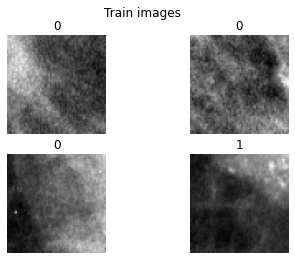

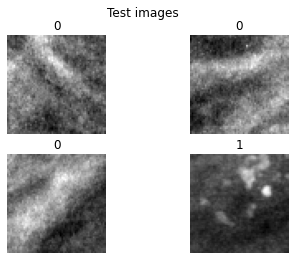

In [29]:
import random 

n = 4

plt.figure(1)
plt.suptitle('Train images')
for i in range(1, n+1):
  r = random.randrange(0, len(x_train))
  Im = x_train[r].squeeze()
  plt.subplot(2, 2, i)
  plt.imshow(Im, cmap = 'gray')
  plt.axis('off')
  plt.title(f'{y_train[r]}')

plt.figure(2)
plt.suptitle('Test images')
for i in range(1, n+1):
  r = random.randrange(0, len(x_test))
  Im = x_train[r].squeeze()
  plt.subplot(2, 2, i)
  plt.imshow(Im, cmap = 'gray')
  plt.axis('off')
  plt.title(f'{y_train[r]}')


#Data augmentation

Convert all 'pgm' images format to 'png' format

In [ ]:
import PIL
import os

In [ ]:
def convert_to_png(fname, dest_folder):
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  dest_fname = os.path.join(dest_folder, dest_fname)
  PIL.Image.open(fname).convert('L').save(dest_fname)

In [ ]:
start_time = time.time()
for data_path in [os.path.join(PATH, "Train"), os.path.join(PATH, "Test")]:
  for path, folders, fnames in os.walk(data_path):
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)
logger.debug('Elapsed time = %.2f s', time.time()-start_time)

#Data aumentation. 

In [19]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Il FLOW_FROM_DIRECTORY takes as input the destination folder path and generates batches of images giving as output an iterator (x, y) where y is the iterator over the labels and x over the images.

Images shape = (batch_size, *target_size, channels) where:

*  batch_size (default = 32) number of images generated from every single x_train image.

Default format of images = png



*  subset = training o validation, funziona solo se c'è validation_split nel 




ImageDataGenerator


IMAGEDATAGENERATOR:
Validation_split = 0.3 divide tutte le N immagini di x_train in: 70% train e 30% validazione e usa questo dataset nel model.fit 


Il.next() accede ad una immagine. train_gen.next()[0] ha shape = (32, 60, 60, 1) cioè per ogni immagine del dataset, lui genera 32 immagini modificate di dimensione 60x60 di colori grayscale

In [20]:
path_to_png_data = os.path.join(PATH, "Train_png")

img_width, img_height = (60, 60)

aug_validation_split = 0.3


train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,  #Rescale every pixel to have a value between 0 and 1
        shear_range=0.2, #Stretches the image 
        zoom_range=0.2, 
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split = aug_validation_split)  
        



train_gen = train_datagen.flow_from_directory(
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')



Found 278 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


# Defining a CNN model

In [21]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.models import Sequential

In [22]:
def make_model(shape=(60, 60, 1)):
  ''' Returns the model'''
  model = Sequential([
      
      Conv2D(50, (5,5), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(60, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
        
      Conv2D(100, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(100, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(50, (4,4), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D(2, 2),

      Flatten(), 
      

      Dense(1, activation='sigmoid')
      
  ])
  
  return model


#Fit model on original dataset

In [23]:
import tensorflow
tensorflow.random.set_seed(2)

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5,
    patience = 5,
    min_lr=0.00001

)

checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


In [25]:
from keras.optimizers import SGD

model = make_model()

model.compile(optimizer=SGD(lr = 0.001, momentum = 0.5), metrics = 'accuracy', loss='binary_crossentropy')

Epoch 1/100
10/10 [==============================] - 1s 30ms/step - loss: 0.6660 - accuracy: 0.6389 - val_loss: 0.6984 - val_accuracy: 0.2857

Epoch 00001: val_accuracy improved from -inf to 0.28571, saving model to model-01-0.29.hdf5
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4136 - accuracy: 0.8025 - val_loss: 0.7319 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.28571
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 0.3077 - accuracy: 0.8644 - val_loss: 0.7520 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.28571
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2890 - accuracy: 0.8677 - val_loss: 0.7597 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.28571
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2936 - accuracy: 0.8911 - val_loss: 0.8134 - val_accuracy: 0.0000e+00

Epoch 00005:

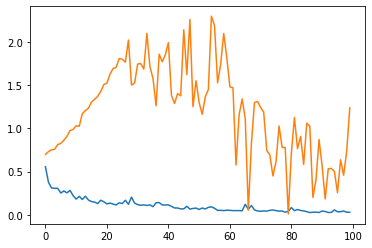

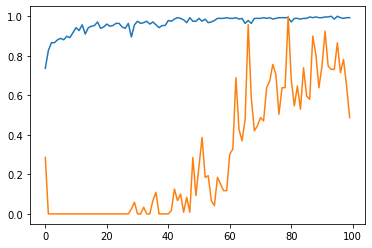

In [26]:
history = model.fit(x_train, y_train, 
                    validation_split=0.3, 
                    epochs=100, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=1)




plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [27]:
model.save(os.path.join(PATH, 'model.hdf5'))
model.evaluate(x_test, y_test)  # returns 'loss' and 'metrics' (accuracy)

13/13 [==============================] - 0s 3ms/step - loss: 0.7937 - accuracy: 0.7182


[0.7936921715736389, 0.7182044982910156]

# Fit model on augmented dataset

In [28]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import SGD

checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5,
    patience = 5,
    min_lr=0.00001
)

STEPS_PER_EPOCH: Definisce il numero di immagini da usare ad ogni epoca, è utile quando il numero delle immagini non è fisso perchè vengono generate potenzialmente infiniti samples

In [29]:
Tot_train_imgs = len(x_train)

In [30]:
import tensorflow
tensorflow.random.set_seed(2)

In [ ]:
model = make_model()


model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


batch_size=32
steps_per_epoch = int(Tot_train_imgs * (1- aug_validation_split))
validation_steps = int(Tot_train_imgs * aug_validation_split)

logger.info('Steps per epoch = %d', steps_per_epoch)
logger.info('Val steps = %d', validation_steps)


history = model.fit(
        train_gen,
        steps_per_epoch = steps_per_epoch // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps= validation_steps // batch_size,
        verbose=1,
        callbacks=[checkpoint])


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

Saving the model

In [32]:
#model.save(os.path.join(PATH, 'model_augmented.hdf5'))

model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 4ms/step - loss: 0.3512 - accuracy: 0.9002


[0.3512449860572815, 0.9002493619918823]

# Comparing the performances of the two trainings

In [ ]:
from keras.models import load_model
aug_model = load_model(os.path.join(PATH, 'model_augmented.hdf5'))
noaug_model = load_model(os.path.join(PATH, 'model.hdf5'))

In [ ]:
noaug_model.evaluate(x_test, y_test)

aug_model.evaluate(x_test, y_test)

#Implement a cross-validation test

In [33]:
from sklearn.model_selection import KFold
from keras.optimizers import SGD

In [36]:
# Define per-fold score arrays
acc_per_fold = []
loss_per_fold = []

# Merge train and test in a single array
X_tot = np.concatenate((x_train, x_test), axis=0)
Y_tot = np.concatenate((y_train, y_test), axis=0)


num_folds = 5

kfold = KFold(n_splits=num_folds, shuffle=True)

batch_size = 32
num_epochs = 30

fold_num = 1

for train, test in kfold.split(X_tot, Y_tot):
  model = make_model()

  model.compile(optimizer=SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')

  history = model.fit(
          X_tot[train], Y_tot[train],
          batch_size = batch_size,
          verbose=0,
          epochs = num_epochs)  
  
  scores = model.evaluate(X_tot[test], Y_tot[test], verbose=0)

  #print(f'Score for fold {fold_nro}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
  print('In folder {:d}: {} of {:.4f} - {} of {:.4f}'.format(fold_num,
                                                          model.metrics_names[0],scores[0],
                                                          model.metrics_names[1], scores[1] ))

  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  fold_num += 1

In folder 1: loss of 0.3205 - accuracy of 0.8562
In folder 2: loss of 0.4139 - accuracy of 0.8125
In folder 3: loss of 0.2368 - accuracy of 0.9057
In folder 4: loss of 0.8509 - accuracy of 0.7799
In folder 5: loss of 0.1981 - accuracy of 0.9245


Computing average scores

In [37]:
print('Average scores for all folds:')
print(f'-- Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'-- Loss: {np.mean(loss_per_fold)}')

Average scores for all folds:
-- Accuracy: 0.8557625770568847 (+- 0.054496696497205656)
-- Loss: 0.40403358936309813
